<a href="https://colab.research.google.com/github/auriwan/Recommendation-system/blob/main/Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anime Recommendation System

Auriwan Yasper

Dataset Anime: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database?select=anime.csv

Dataset Rating: https://www.kaggle.com/datasets/azathoth42/myanimelist

# Pendahuluan

Tema dari analisis ini adalah hiburan dimana hasilnya akan berupa model machine learning yang nanti dapat digunakan untuk dijadikan sebuah sistem rekomendasi anime

# Data Loading

**Import Library**

In [1]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive

In [2]:
!pip install -q kaggle

In [3]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/"

In [5]:
!chmod 600 /content/gdrive/MyDrive/kaggle.json

**Download Dataset Anime**

In [6]:
! KAGGLE_CONFIG_DIR=/content/gdrive/MyDrive kaggle datasets download -d CooperUnion/anime-recommendations-database

 84% 21.0M/25.0M [00:00<00:00, 214MB/s]
100% 25.0M/25.0M [00:00<00:00, 229MB/s]


Download Dataset Rating

In [7]:
! KAGGLE_CONFIG_DIR=/content/gdrive/MyDrive kaggle datasets download -d marlesson/myanimelist-dataset-animes-profiles-reviews

 98% 213M/217M [00:02<00:00, 133MB/s]
100% 217M/217M [00:02<00:00, 93.7MB/s]


**Ekstrak Dataset Anime**

In [8]:
file = '/content/anime-recommendations-database.zip'
zip_ref = zipfile.ZipFile(file, 'r')
zip_ref.extractall('/dataset_baru/')
zip_ref.close()

**Extrak dataset Rating**

In [9]:
file = '/content/myanimelist-dataset-animes-profiles-reviews.zip'
zip_ref = zipfile.ZipFile(file, 'r')
zip_ref.extractall('/dataset_baru/')
zip_ref.close()

# **Data Understanding**

dataset ini bersumber dari kaggle dataset dengan 2 sumber dataset, dataset pertama akan digunakan untuk dataset anime dan dataset kedua digunakan untuk dataset rating

**Membuat data frame anime dan rating**

dan kita tampilkan 5 data pertama anime dan rating

In [10]:
df_anime = pd.read_csv('/dataset_baru/anime.csv')
df_rating = pd.read_csv('/dataset_baru/reviews.csv')

df_anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [11]:
df_rating.head()

,uid,profile,anime_uid,text,score,scores,link
0,255938,DesolatePsyche,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938
1,259117,baekbeans,34599,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=259117
2,253664,skrn,28891,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=253664
3,8254,edgewalker00,2904,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=8254
4,291149,aManOfCulture99,4181,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=291149


# Exploratory Data Analysis



**Univariate Analysis**

**Deskripsi Variable**

- Variable yang akan digunakan pada anime.csv
  - anime_id = ID dari anime
  - name = Judul Anime
  - genre = Genre dari anime
  - rating = Rating Anime

- Variable pada file users_cleaned.csv
  - user_id = id dari user 
  - anime_id
  - rating = rating yang diberikan user

In [12]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


Selanjutnya memilih column yang diperlukan

In [13]:
df_anime = df_anime[['anime_id', 'genre', 'name', 'rating']]

In [14]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192112 entries, 0 to 192111
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   uid        192112 non-null  int64 
 1   profile    192112 non-null  object
 2   anime_uid  192112 non-null  int64 
 3   text       192112 non-null  object
 4   score      192112 non-null  int64 
 5   scores     192112 non-null  object
 6   link       192112 non-null  object
dtypes: int64(3), object(4)
memory usage: 10.3+ MB


Memilih column Dataset rating yang diperlukan

In [15]:
df_rating = df_rating[['uid', 'anime_uid', 'score']]

In [16]:
df_anime['rating'].describe()

count    12064.000000
mean         6.473902
std          1.026746
min          1.670000
25%          5.880000
50%          6.570000
75%          7.180000
max         10.000000
Name: rating, dtype: float64

dari data diatas dapat dilihat bahwa skala dari rating yang diberikan adalah 1-10

Selanjutnya kita akan melihat data genre yang terdapat pada dataset anime sebagai berikut

In [17]:
for x in range(len(df_anime)):
  df_anime['genre'][x] = str(df_anime['genre'][x]).split(',')[0]

df_anime[['genre', 'name']].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,genre,name
0,Drama,Kimi no Na wa.
1,Action,Fullmetal Alchemist: Brotherhood
2,Action,Gintama°
3,Sci-Fi,Steins;Gate
4,Action,Gintama&#039;


In [18]:
genres = df_anime['genre'].unique().tolist()
print("All genres : {}".format(genres))
print("Genres amount : {}".format(len(genres)))

All genres : ['Drama', 'Action', 'Sci-Fi', 'Comedy', 'Adventure', 'Fantasy', 'Mystery', 'Psychological', 'Ecchi', 'Josei', 'Military', 'Romance', 'Demons', 'Dementia', 'Music', 'Game', 'Cars', 'Mecha', 'Horror', 'School', 'Historical', 'Kids', 'Shounen', 'Shoujo', 'Magic', 'Harem', 'Martial Arts', 'Sports', 'Slice of Life', 'Seinen', 'nan', 'Parody', 'Police', 'Thriller', 'Supernatural', 'Samurai', 'Super Power', 'Vampire', 'Space', 'Hentai', 'Yaoi']
Genres amount : 41


Jadi pada dataset terdapat 41 genre yang tersedia, dan kita akan membuat visualisasinya sebagai berikut

In [19]:
df_visual_genres = df_anime.groupby('genre')['name'].count().reset_index().sort_values('name', ascending=False).head(10)
df_visual_genres

,genre,name
3,Comedy,3193
0,Action,2845
1,Adventure,1457
6,Drama,991
11,Hentai,947
8,Fantasy,494
20,Music,403
15,Kids,396
4,Dementia,206
12,Historical,170


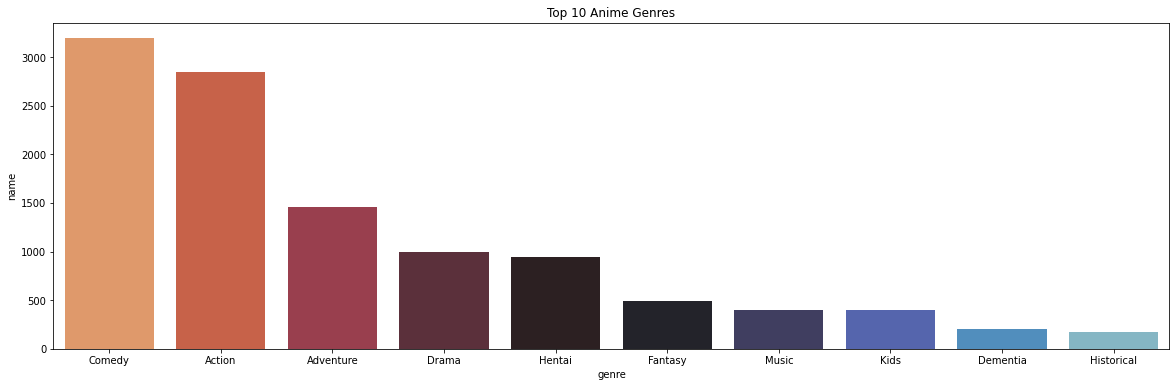

In [20]:
plt.figure(figsize=(20,6))
plt.title('Top 10 Anime Genres')
sns.barplot(x="genre", y="name", data=df_visual_genres, palette='icefire_r')
plt.show()

# Data Preparation

**Mengecek Missing Value**

In [21]:
df_anime.isnull().sum()

anime_id      0
genre         0
name          0
rating      230
dtype: int64

terdapat 230 missing value pada column rating dataset anime, maka kita akan menghaspus data tersebut

In [22]:
df_anime.dropna(axis=0, inplace=True)

In [23]:
df_rating.isnull().sum()

uid          0
anime_uid    0
score        0
dtype: int64

untuk dataset rating tidak terdapat missing value

In [24]:
df_anime.isnull().sum()

anime_id    0
genre       0
name        0
rating      0
dtype: int64

**Mengecek data Duplikat**

In [25]:
df_anime.duplicated().sum()

0

In [26]:
df_rating.duplicated().sum()

61593

pada data rating terdapat 61593 data duplikat dan data ini akan kita hapus saja

In [27]:
df_rating.drop_duplicates(subset=['uid','anime_uid'], keep='first', inplace=True)
df_rating.duplicated().sum()

0

# Model Development



# **Content-Based-Filtering**



pertama kita akan mempersiapkan data untuk cosine similarity dengan TfidfVectorizer, lalu mendapatkan fiur penting pada data genre 

In [28]:
tfid = TfidfVectorizer(stop_words='english')
tfid.fit(df_anime['genre'])
tfid.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['action',
 'adventure',
 'arts',
 'cars',
 'comedy',
 'dementia',
 'demons',
 'drama',
 'ecchi',
 'fantasy',
 'fi',
 'game',
 'harem',
 'hentai',
 'historical',
 'horror',
 'josei',
 'kids',
 'life',
 'magic',
 'martial',
 'mecha',
 'military',
 'music',
 'mystery',
 'nan',
 'parody',
 'police',
 'power',
 'psychological',
 'romance',
 'samurai',
 'school',
 'sci',
 'seinen',
 'shoujo',
 'shounen',
 'slice',
 'space',
 'sports',
 'super',
 'supernatural',
 'thriller',
 'vampire',
 'yaoi']

selanjutnya kita akan melakukan fitting dan mengubah kedalam bentuk matriks

In [29]:
tfidf_matrix = tfid.fit_transform(df_anime['genre']) 
tfidf_matrix.shape

(12064, 45)

angka diatas adalah ukuran dari matriks kita, dan untuk melihat vektor tf-idf dalam bentuk matriks kita jalankan kode berikut

In [30]:
cosine_sim = cosine_similarity(tfidf_matrix)
print(cosine_sim.shape)
cosine_sim

(12064, 12064)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

dari matriks tf-idf diatas kita lihat bagaimana similarity dari dataset anime yang kita miliki

In [31]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=df_anime['name'],
                             columns=df_anime['name'])
print('Size dataframe:', cosine_sim_df.shape)
cosine_sim_df.sample(10, axis=1).sample(10, axis=0)

Size dataframe: (12064, 12064)


name,X Bomber,Soccer Fever,Jungle de Ikou!,"Ano Hi, Bokura wa Senjou de: Shounenhei no Kokuhaku",Choujin Gakuen Gowcaizer: The Voltage Fighters,Baka Misérables,Zenmai Zamurai,Wazaguu! vs. Dangerous Jiisan Ja: Houfukuzettou! Anime Quiz,Hanada Shounen-shi,Flag Director&#039;s Edition: Issenman no Kufura no Kiroku
name,,,,,,,,,,
Nanocore: 2016 New Year Special,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Machine-Doll wa Kizutsukanai,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
Kochira Tamago Outou Negaimasu,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
Kyouryoku Boukuusen,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
Super GALS! Kotobuki Ran,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
Don Chuck Monogatari,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Stratos 4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
Cyclops Shoujo Saipuu,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
Fushigi no Umi no Nadia: Original Movie,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# Model Function

selanjutnya kita akan membuat fungsi untuk merekomendasikan 10 anime berdasarkan similaritynya 

In [32]:
def AnimeRecommendations(anime_name, similarity_data=cosine_sim_df, 
                         items=df_anime[['anime_id','name','genre']], k=10):
  
    ''' Mengambil data menggunakan argpartition untuk partisi secara tidak langsung,
    sepanjang sumbu yang diberikan, kemudian dataframe diubah menjadi numpy Range 
    dengan parameter sebagai berikut (start, stop, step) '''
    index = similarity_data.loc[:, anime_name].to_numpy().argpartition(
        range(-1, -k, -1)
    )
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(anime_name, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

dan kita lihat dulu untuk data yang akan kita gunakan sebagai anime referensi yang akan kita jadika acuan dalam rekomendasi

In [33]:
find_name = df_anime[df_anime['name'] == 'Cowboy Bebop']
find_name

,anime_id,genre,name,rating
22,1,Action,Cowboy Bebop,8.82


bisa kita lihat bahwa genre dari anime diatas adalah action, dan seharusnya anime 10 rekomendasi dari fungsi kita juga seharusnya anime bertipe action

In [34]:
anime_name = 'Cowboy Bebop'
anime_recomend = AnimeRecommendations(anime_name)
anime_recomend

,name,anime_id,genre
0,Seikai no Monshou Special,1381,Action
1,Qi Cai Lao Fu Zi,30095,Action
2,Qin Shiming Yue 3D: Dianying Longteng Wanli,29910,Action
3,Game Tengoku OVA,10852,Action
4,Qin Shiming Yue Zhi: Guoqing Tebie Pian,33258,Action
5,Qin Shiming Yue Zhi: Wanli Changcheng,15905,Action
6,Qin Shiming Yue Zhi: Luosheng Tangxia,29937,Action
7,Qin Shiming Yue Zhi: Tian Xing Jiu Ge,29935,Action
8,Qin Shiming Yue Zhi: Junlin Tianxia,29936,Action
9,Qin Shiming Yue Tebie Pian: Di Zi Jiang Xi,33278,Action


# Collaborative Filtering

pertama kita perlu menggabungkan data anime dan rating terlebih dahulu, dan menyamakan variabel yang akan kita gabungkan

In [35]:
df_anime.columns = ['anime_id', 'genre', 'name', 'Rating']
df_anime.head()

,anime_id,genre,name,Rating
0,32281,Drama,Kimi no Na wa.,9.37
1,5114,Action,Fullmetal Alchemist: Brotherhood,9.26
2,28977,Action,Gintama°,9.25
3,9253,Sci-Fi,Steins;Gate,9.17
4,9969,Action,Gintama&#039;,9.16


In [36]:
df_rating.columns = ['user_id', 'anime_id', 'rating']
df_rating.head()

,user_id,anime_id,rating
0,255938,34096,8
1,259117,34599,10
2,253664,28891,7
3,8254,2904,9
4,291149,4181,10


In [37]:
rating_anime = pd.merge(df_rating, df_anime, on='anime_id', how='inner')
rating_anime.drop(['Rating'],axis=1, inplace=True)
rating_anime.head()

,user_id,anime_id,rating,genre,name
0,253664,28891,7,Comedy,Haikyuu!! Second Season
1,254554,28891,10,Comedy,Haikyuu!! Second Season
2,271227,28891,10,Comedy,Haikyuu!! Second Season
3,284956,28891,7,Comedy,Haikyuu!! Second Season
4,249279,28891,8,Comedy,Haikyuu!! Second Season


# Visualisasi sebaran 10 anime dengan rating tertinggi

In [38]:
rating_anime_count = rating_anime.groupby('name')['rating'].count()
rating_anime_count = pd.DataFrame(rating_anime_count).reset_index().rename(columns={'rating':'total_rating'})
rating_anime_count.head()

,name,total_rating
0,&quot;0&quot;,3
1,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hat...,2
2,&quot;Bungaku Shoujo&quot; Memoire,3
3,&quot;Bungaku Shoujo&quot; Movie,28
4,&quot;Eiji&quot;,1


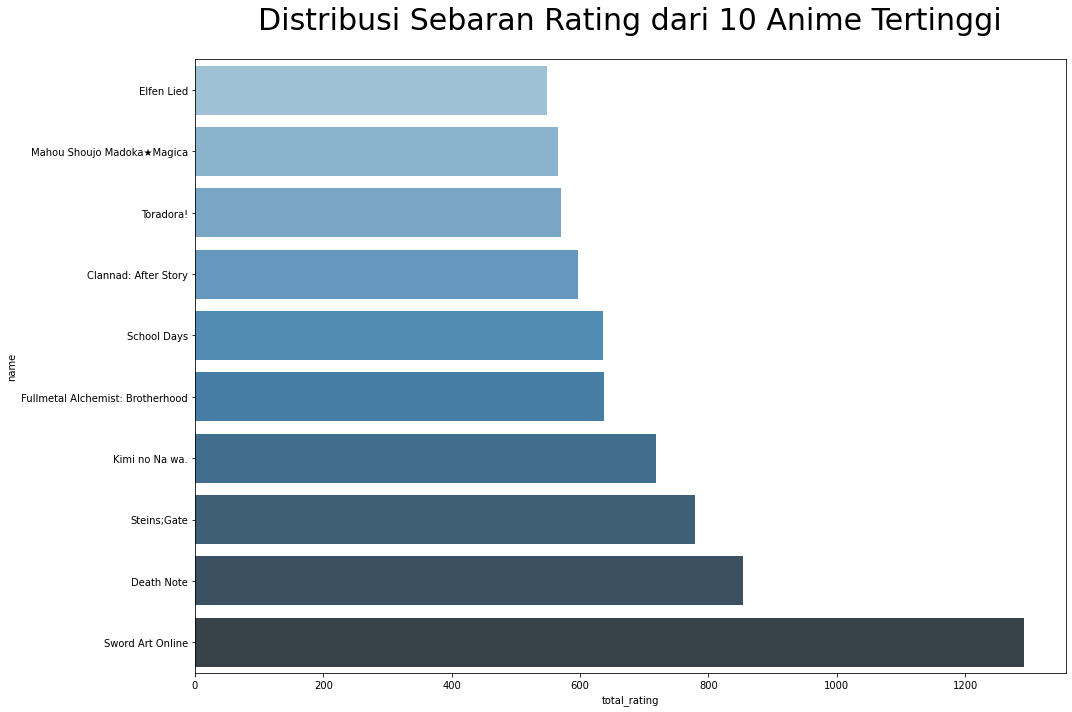

In [39]:
data = rating_anime_count.sort_values(by ='total_rating')

plt.figure(figsize=(15,10))
sns.barplot(data=data.iloc[-10:,:], 
            y='name', x='total_rating',
            palette="Blues_d")
plt.title('Distribusi Sebaran Rating dari 10 Anime Tertinggi', pad=30, fontsize=30)
plt.tight_layout()
plt.show()

dari data diatas bisa kita lihat anime dengan rating tertinggi dipegang oleh Sword art online

selanjutnya kita akan mengambil data rating ini sebagai data utama kita dengan nama merge_df

In [40]:
merge_df = rating_anime
merge_df.head()

,user_id,anime_id,rating,genre,name
0,253664,28891,7,Comedy,Haikyuu!! Second Season
1,254554,28891,10,Comedy,Haikyuu!! Second Season
2,271227,28891,10,Comedy,Haikyuu!! Second Season
3,284956,28891,7,Comedy,Haikyuu!! Second Season
4,249279,28891,8,Comedy,Haikyuu!! Second Season


# Data preparation

pada tahap ini kita akan mengubah unique user_id dan anime_id menjadi list, lalu melakukan encoding user_id dan encoding anime_id, dan encoding angka ke user_id dan anime

In [41]:
user_id = merge_df['user_id'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_id)}
user_encoded_to_user = {i: x for i, x in enumerate(user_id)}

In [42]:
anime_id = merge_df['anime_id'].unique().tolist()
anime_to_anime_encoded = {x: i for i, x in enumerate(anime_id)}
anime_encoded_to_anime = {i: x for i, x in enumerate(anime_id)}

Selanjutnya kita melakukan mapping data user id dan anime id

In [43]:
merge_df['user'] = merge_df['user_id'].map(user_to_user_encoded)
merge_df['anime'] = merge_df['anime_id'].map(anime_to_anime_encoded)
merge_df.head()

,user_id,anime_id,rating,genre,name,user,anime
0,253664,28891,7,Comedy,Haikyuu!! Second Season,0,0
1,254554,28891,10,Comedy,Haikyuu!! Second Season,1,0
2,271227,28891,10,Comedy,Haikyuu!! Second Season,2,0
3,284956,28891,7,Comedy,Haikyuu!! Second Season,3,0
4,249279,28891,8,Comedy,Haikyuu!! Second Season,4,0


selanjutnya kita akan mendapatkan jumlah user dan anime, lalu merubah tipe data variabel rating menjadi float, lalu melihat nilai maksimum dan nilai minimum pada rating

In [44]:
num_users = len(user_to_user_encoded)
num_anime = len(anime_encoded_to_anime)
merge_df['rating'] = merge_df['rating'].values.astype(np.float32)
min_rating = min(merge_df['rating'])
max_rating = max(merge_df['rating'])

print(f'Number of User: {num_users}')
print(f'Number of anime: {num_anime}')
print(f'Min rating: {min_rating}')
print(f'Max rating: {max_rating}')

Number of User: 107039
Number of anime: 6783
Min rating: 0.0
Max rating: 11.0


# Pembagian dataset training dan test

sebelum kita masuk pembagian dataset kita akan melakukan acak dataset

In [45]:
df = merge_df.sample(frac=1, random_state=30)
df.head()

,user_id,anime_id,rating,genre,name,user,anime
101456,128373,19221,10.0,Comedy,"Ore no Nounai Sentakushi ga, Gakuen Love Comed...",101456,6447
78255,134673,11757,6.0,Action,Sword Art Online,78255,4088
10798,273956,21647,9.0,Comedy,Tamako Love Story,10798,218
103310,254578,19117,10.0,Adventure,Toaru Hikuushi e no Koiuta,103310,6533
63246,173605,21881,8.0,Action,Sword Art Online II,63246,2783


Tahap selanjutnya kita akan membuat sebuat variabel x yang akan menampung data user dan anime, dan variabel y untuk menampung data rating. selanjutnya kita akan membagi dataset sebanyak 80% data train dan 20% data test

In [46]:
x = merge_df[['user', 'anime']].values
y = merge_df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
train_indices = int(0.8 * merge_df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

# Melatih model

pertama kita akan membuat class dan fungsi inisialisasi

In [47]:
class RecommenderNet(tf.keras.Model):
  def __init__(self, num_users, num_anime, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_anime = num_anime
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(5e-7)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.anime_embedding = layers.Embedding(
        num_anime,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(5e-7)
    )
    self.anime_bias = layers.Embedding(num_anime, 1)
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    anime_vector = self.anime_embedding(inputs[:, 1])
    anime_bias = self.anime_bias(inputs[:, 1])
 
    dot_user_anime = tf.tensordot(user_vector, anime_vector, 2) 
 
    x = dot_user_anime + user_bias + anime_bias
    
    return tf.nn.sigmoid(x)

**Compile Model dan membuat callback**

In [48]:
model = RecommenderNet(num_users, num_anime, 50) # inisialisasi model

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()]]
)
callbacks = EarlyStopping(
    min_delta=0.0001,
    patience=7,
    restore_best_weights=True,
)

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val),
    callbacks=[callbacks]
)

Epoch 1/100
 2641/10704 [======>.......................] - ETA: 6:46 - loss: 0.5802 - mean_absolute_error: 0.1144 - root_mean_squared_error: 0.1525

Selanjutnya kita akan menguji dengan salah satu sampel user dan menguji rekomendasi dengan model yang sudah kita rancang

In [ ]:
user_id = merge_df.user_id.sample(1).iloc[0]
anime_watched_by_user = merge_df[merge_df.user_id == user_id]
 
anime_not_watched = df_anime[~df_anime['anime_id'].isin(anime_watched_by_user.anime_id.values)]['anime_id'] 
anime_not_watched = list(
    set(anime_not_watched)
    .intersection(set(anime_to_anime_encoded.keys()))
)

 
anime_not_watched = [[anime_to_anime_encoded.get(x)] for x in anime_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

In [ ]:
ratings = model.predict(user_anime_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_anime_ids = [
    anime_encoded_to_anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(user_ID))
print('====' * 10)
print('movie with high ratings from user')
print('----' * 8)
 
top_anime_user = (
    anime_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)
 
anime_df_rows = df_anime[df_anime['anime_id'].isin(top_anime_user)]
for row in anime_df_rows.itertuples():
    print(row.title)
 
print('----' * 8)
print('Top 10 anime recommendation')
print('----' * 8)
 
recommended_anime = df_anime[df_anime['anime_id'].isin(recommended_anime_ids)]
for row in recommended_anime.itertuples():
    print(row.title)

# Evaluation

Pada tahap ini penulis menggunakan dua teknik yaitu :

- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)

Dan untuk Sistem Rekomendasi Content Based Filtering Saya menggunakan Precision

# Plot Grafik MAE

In [ ]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model_metrics')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['mean_absolute_error', 'val_mean_absolute_error'])
plt.show()

# Plot Grafik RMSE

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['root_mean_squared_error', 'val_root_mean_squared_error'])
plt.show()

# Precision

In [ ]:
def MovieRecommendations(anime_title, similarity_data=cosine_sim_df, 
                         items=df_anime[['anime_id','name','genre']], k=10):
  
    ''' Mengambil data menggunakan argpartition untuk partisi secara tidak langsung,
    sepanjang sumbu yang diberikan, kemudian dataframe diubah menjadi numpy Range 
    dengan parameter sebagai berikut (start, stop, step) '''
    index = similarity_data.loc[:, anime_title].to_numpy().argpartition(
        range(-1, -k, -1)
    )
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(anime_title, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

In [ ]:
find_title = df_anime[df_anime['name'] == 'Naruto']
find_title

In [ ]:
anime_title = 'Naruto'
anime_recomend = MovieRecommendations(anime_title)
anime_recomend

Dari hasil rekomendasi di atas, diketahui bahwa Outbreak (1995) memiliki 4 genre. Dari 10 item yang direkomendasikan, 8 item memiliki kategori 4 genre yang sama (similar). Artinya, precision sistem kita sebesar 8/10 atau sebesar 80%.

Precision = #of recommendation that are relevant/#of item we recommend. Pada contoh rekomendasi di atas: Precision = 8/10. Jadi presisinya = 80%